# Customer Engagement and Churn

### Define a target metric to measure user engagement.
User unengagement could ultimately lead to churn, it is one of the most important metrics for a growing business to evalute as acquiring a new customer is significantly more expensive than retaining an existing one. With the given data, I have chosen to set **Transaction Frequency** as the target metric. 

Given the 4 datasets, user, devices and notification data could provide us insights into possible factors causing customers to become unengaged, however we could not obtain anything on how they interact with us. Whilst the transaction data provide us very useful information: Usage.

**Transaction Frequency** tells us how often the users interact with our services regardless of the account created date, especially when the timeframe of the datasets is not very long, it would be difficult to yield any long term patterns such as 'inactivity in a 6-month period'. The transaction frequency of a user is measured as the total number of completed transactions over the time between the user's account created date to the last ever transaction made by any user in the dataset, with the assumption that that was last piece data collected and the data was summarised and marked the end of timeframe (instead of using the last transaction date of each user, it is to avoid extreme values eg. users who made one transaction on the very day they created the account and never used again).

Metric: Users with transaction frequency **below** (mean - one standard deviation) is considered **unengaged**. This would give us about 20% unengagement rate.

Other metrics as listed below would not be appropriate:
1. Total count of transaction - As some users opened their account a lot later hence it is an unfair comparison.

2. Total amount of money transferred - it is not representative as some users naturally do not spend as much but could be actively making small transactions

3. Activity before vs after receiving a notification - it is unsure if every user received the same number of notifications and the timing.

4. User inactivity - again, the total timeframe is too short to yield any convincing patterns, also the setting an inactivity period could be arbitrary and ambiguous.

With that in mind, let's dive into the technical part.

#### The Dataset

In [1]:
# import required libraries for data wrangling and visualisation
import statistics 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import interp
from functools import reduce
from datetime import datetime
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, plot_confusion_matrix, roc_curve, auc

%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
# read dataframes

df_users = pd.read_csv('data/rev-users.csv')
df_devices = pd.read_csv('data/rev-devices.csv')
df_transactions = pd.read_csv('data/rev-transactions.csv')
df_notifications = pd.read_csv('data/rev-notifications.csv')

Transaction data Feature Engineering

In [3]:
# drop features with high cardinality and unuseful data for simplicity
# drop columns such as transaction type count that could lead to overfitting in the final model

columns_to_drop = ['direction', 'transactions_type', 'transactions_state', 'transactions_currency',
                   'ea_cardholderpresence', 'ea_merchant_mcc', 
                   'ea_merchant_city', 'ea_merchant_country']

df_transactions = df_transactions[df_transactions['transactions_state']=='COMPLETED']

df_transactions.drop(columns_to_drop, axis=1, inplace=True)

In [4]:
# group by user_id and aggregate 

df_transactions = df_transactions.groupby('user_id').agg({'amount_usd':np.sum,
                                                          'transaction_id': lambda x: x.nunique(),
                                                          'created_date': lambda x: x.max()})

df_transactions.rename({'created_date': 'last_transaction',
                        'transaction_id': 'transactions_count'}
                       , axis ='columns'
                       , inplace =True)

In [5]:
# extract account est. dates

df_transactions = pd.merge(left = df_users[['user_id', 'created_date']],
                           right = df_transactions,
                           how = 'inner',
                           on = 'user_id')

df_transactions['average_transaction_amount'] = df_transactions['amount_usd']/df_transactions['transactions_count']

In [6]:
# define functions to convert time

def diff_dates(date1: str, date2: str) -> datetime:
    """cast strings to dates and calculate difference between them"""
    
    date1 = datetime.strptime(date1,'%Y-%m-%d %H:%M:%S.%f')
    date2 = datetime.strptime(date2,'%Y-%m-%d %H:%M:%S.%f')
    
    return date1 - date2


def date_days(td: datetime) -> float:
    """convert datetime to number of days"""
    
    return td.days + td.seconds / (60*60*24)

In [7]:
# calculate frequency

df_transactions['transaction_frequency'] = ''

for user in range(len(df_transactions)):
    
    transaction_count = df_transactions['transactions_count'][user].astype(float)
    last_transaction_date = df_transactions['last_transaction'].max()
    created_date = df_transactions['created_date'][user]
    date_diff = diff_dates(last_transaction_date, created_date)
    
    df_transactions['transaction_frequency'][user] = transaction_count / date_days(date_diff)

In [8]:
# transform frequency from skewed to a normal distribution

df_transactions['transaction_frequency'] = df_transactions['transaction_frequency'].astype(float)

df_transactions['transaction_freq_log10'] = np.log10(df_transactions['transaction_frequency'])

In [9]:
# normalise

min_freq = df_transactions['transaction_freq_log10'].min()
max_freq = df_transactions['transaction_freq_log10'].max()

df_transactions['transaction_freq_normalised'] = (df_transactions['transaction_freq_log10'] - min_freq) / (max_freq - min_freq)

In [10]:
df_transactions.drop(['created_date', 'last_transaction', 'transaction_frequency', 'transaction_freq_log10'], axis=1, inplace=True)

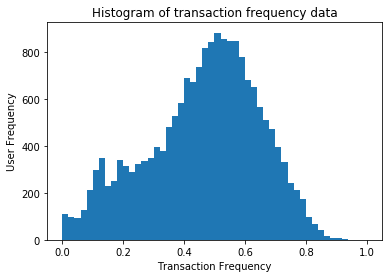

In [11]:
plt.hist(df_transactions['transaction_freq_normalised'], bins = 50)
plt.xlabel('Transaction Frequency')
plt.ylabel('User Frequency')
plt.title('Histogram of transaction frequency data')
plt.show()

In [12]:
# assign 'engaged' label to users lower than -1 standard deviation

df_transactions['engaged'] = ''

lower_sd = df_transactions['transaction_freq_normalised'].mean() - df_transactions['transaction_freq_normalised'].std()

for user in range(len(df_transactions)):
    if df_transactions['transaction_freq_normalised'][user] < lower_sd:
        df_transactions['engaged'][user] = 0
    else:
        df_transactions['engaged'][user] = 1

In [13]:
df_transactions['engaged'].value_counts()

1    15188
0     3341
Name: engaged, dtype: int64

As seen, about 18% customers are considered unengaged with usage below standard.

### Model Building for User Engagement Classification
Random Forest is chosen for the model development for a number of reasons:
* an easy-to-use supervised classification algorithm
* performs well on imbalanced date ie. user plan, notification status
* corrects for decision trees' habit of overfitting
* tree-based models do not require feature scaling
* comes with feature importance for selecting the most contributing features

We will pick up from where we left off in question 2.

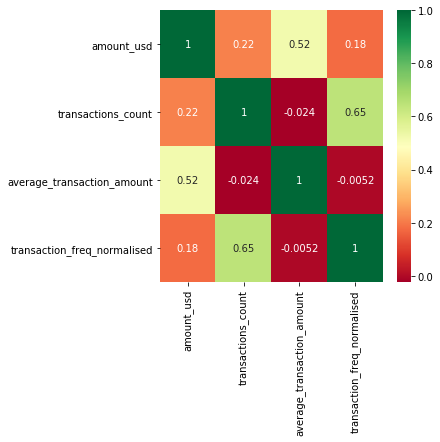

In [14]:
# plot heat map correlations of each features in dataset to identify highly correlated features

corrmat = df_transactions.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (5,5))
g = sns.heatmap(df_transactions[top_corr_features].corr(),annot = True,cmap = "RdYlGn")

In [15]:
# remove features that could overfit the model

df_transactions.drop('transactions_count', axis = 1, inplace = True)

In [16]:
# pre-process df_devices 

df_devices = df_devices[df_devices['brand'] != 'Unknown']
brand_dummies = pd.get_dummies(df_devices['brand'], prefix = 'brand')
df_devices = pd.concat([df_devices, brand_dummies], sort = False, axis = 1)

df_devices.drop(['brand','brand_Apple'], axis = 1, inplace = True)

Device data pre-processing

In [17]:
# one-hot encoding for categorical variables

columns_dummies = ['reason', 'status']

for column in columns_dummies:
    dummies = pd.get_dummies(df_notifications[column], prefix = column)
    df_notifications.drop(column, axis = 1, inplace = True)
    df_notifications = pd.concat([df_notifications, dummies], sort = False, axis=1)

In [18]:
# aggregate dateframe by user_id

df_notifications.drop('channel', axis = 1, inplace = True)

df_notifications = df_notifications.groupby(['user_id']).agg(lambda x : x.sum() if x.dtype == 'uint8'
                                                             else x.max())

In [19]:
# extract account create dates to dataframe for notification frequency calculation

df_notifications = pd.merge(left = df_users[['user_id', 'created_date']],
                   right = df_notifications,
                   how = 'inner',
                   on = 'user_id')

In [20]:
# calculate notification frequency

df_notifications['notifications_frequency'] = ''

for user in range(len(df_notifications)):
    
    notifications_count = df_notifications['status_FAILED'][user] + df_notifications['status_SENT'][user]
    last_notification_date = df_notifications['created_date_y'].max()
    created_date = df_notifications['created_date_x'][user]
    date_diff = diff_dates(last_notification_date, created_date)
    
    df_notifications['notifications_frequency'][user] = notifications_count / date_days(date_diff)

df_notifications.drop(['created_date_x', 'created_date_y'], axis = 1, inplace = True)

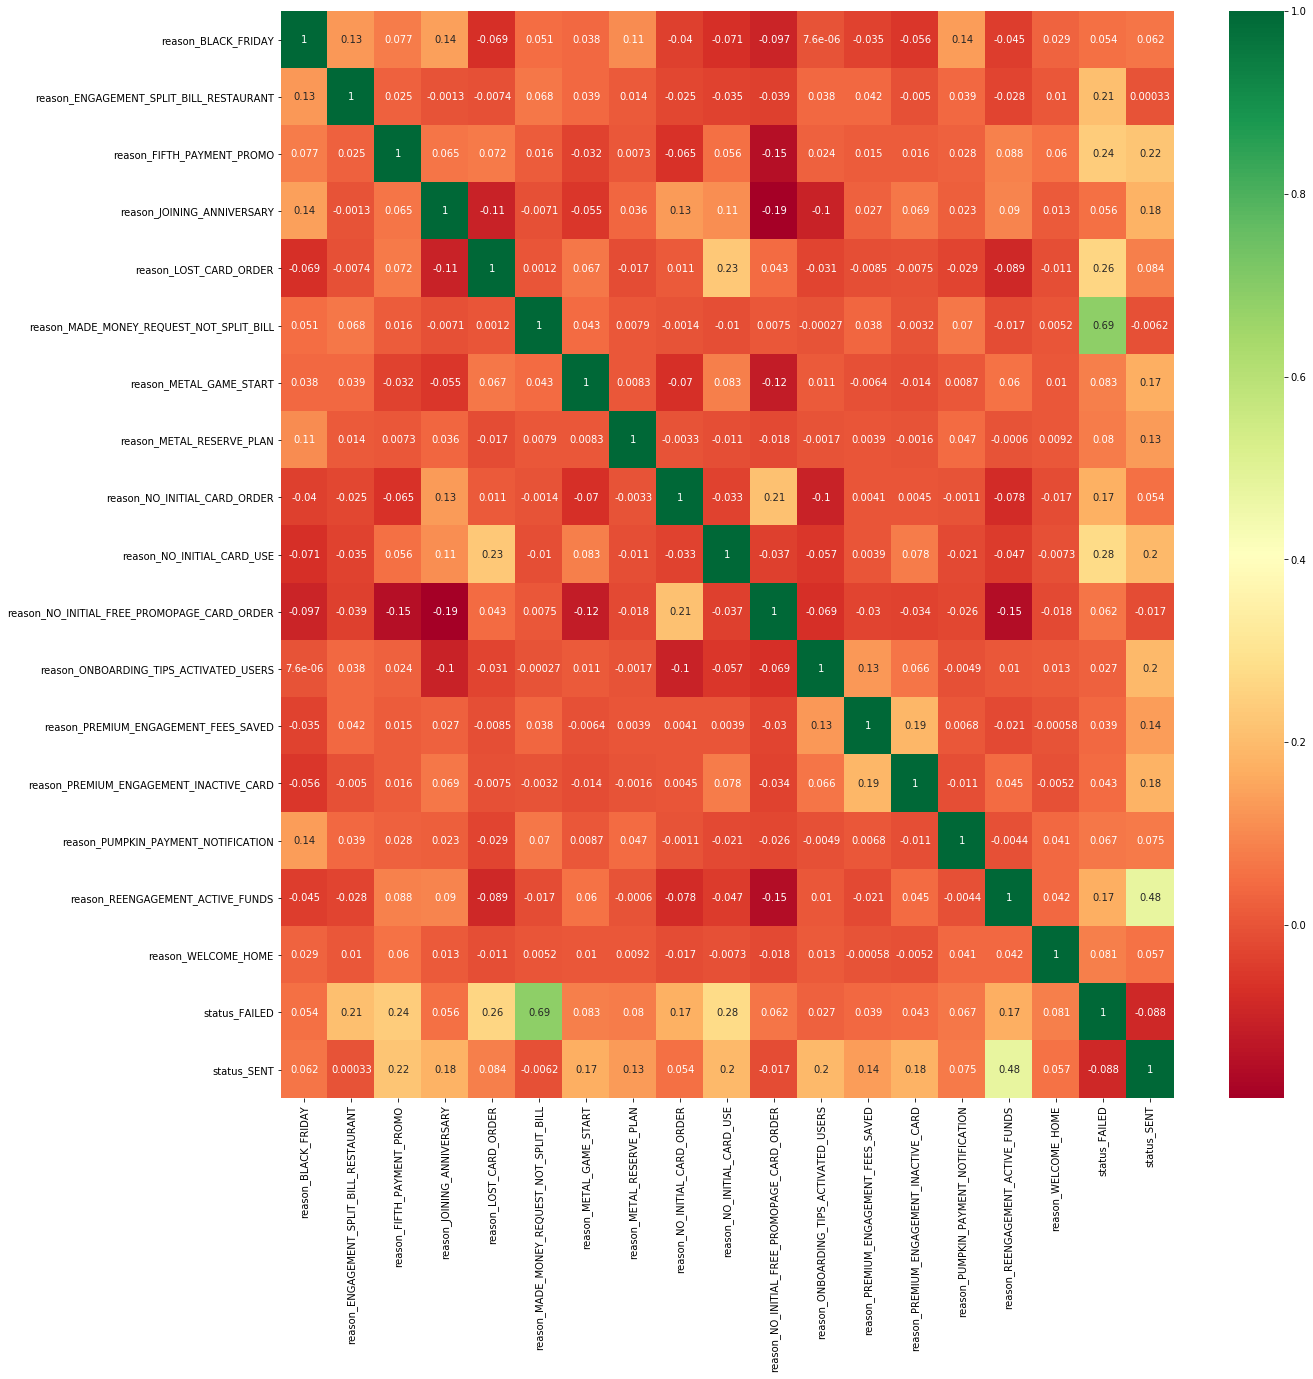

In [21]:
# plot heat map correlations of each features in dataset to identify highly correlated features

corrmat = df_notifications.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))
g = sns.heatmap(df_notifications[top_corr_features].corr(),annot = True,cmap = "RdYlGn")

In [22]:
# remove features that could overfit the model

df_notifications.drop('reason_MADE_MONEY_REQUEST_NOT_SPLIT_BILL', axis = 1,inplace = True)

User data pre-processing

In [23]:
# drop features with high % of missing values and cardinality

columns_to_drop = ['city', 'num_referrals', 'num_successful_referrals']

df_users.drop(columns_to_drop, axis = 1, inplace = True)

In [24]:
# create binary indicator for missing notification setting

df_users['attributes_notifications_missing']=''

for i in range(len(df_users)):
    
    if df_users['attributes_notifications_marketing_push'][i] >= 0:
        df_users['attributes_notifications_missing'][i] = 0
    else:
        df_users['attributes_notifications_missing'][i] = 1

In [25]:
# one-hot encoding for categorical variables

columns_dummies = ['country', 'plan', 'user_settings_crypto_unlocked',
                   'attributes_notifications_marketing_push',
                   'attributes_notifications_marketing_email']

for column in columns_dummies:
    dummies = pd.get_dummies(df_users[column], prefix = column)
    df_users.drop(column, axis = 1,inplace = True)
    df_users = pd.concat([df_users, dummies], sort = False, axis = 1)
    
df_users.drop('user_settings_crypto_unlocked_0', axis = 1,inplace = True)

In [26]:
# convert created date to age of account

df_users['account_age'] = ''

for i in range(len(df_users)):
    
    df_users['account_age'][i] = diff_dates(df_users['created_date'][i], df_users['created_date'].min())
    df_users['account_age'][i] = date_days(df_users['account_age'][i])
    
df_users.drop('created_date', axis = 1,inplace = True)

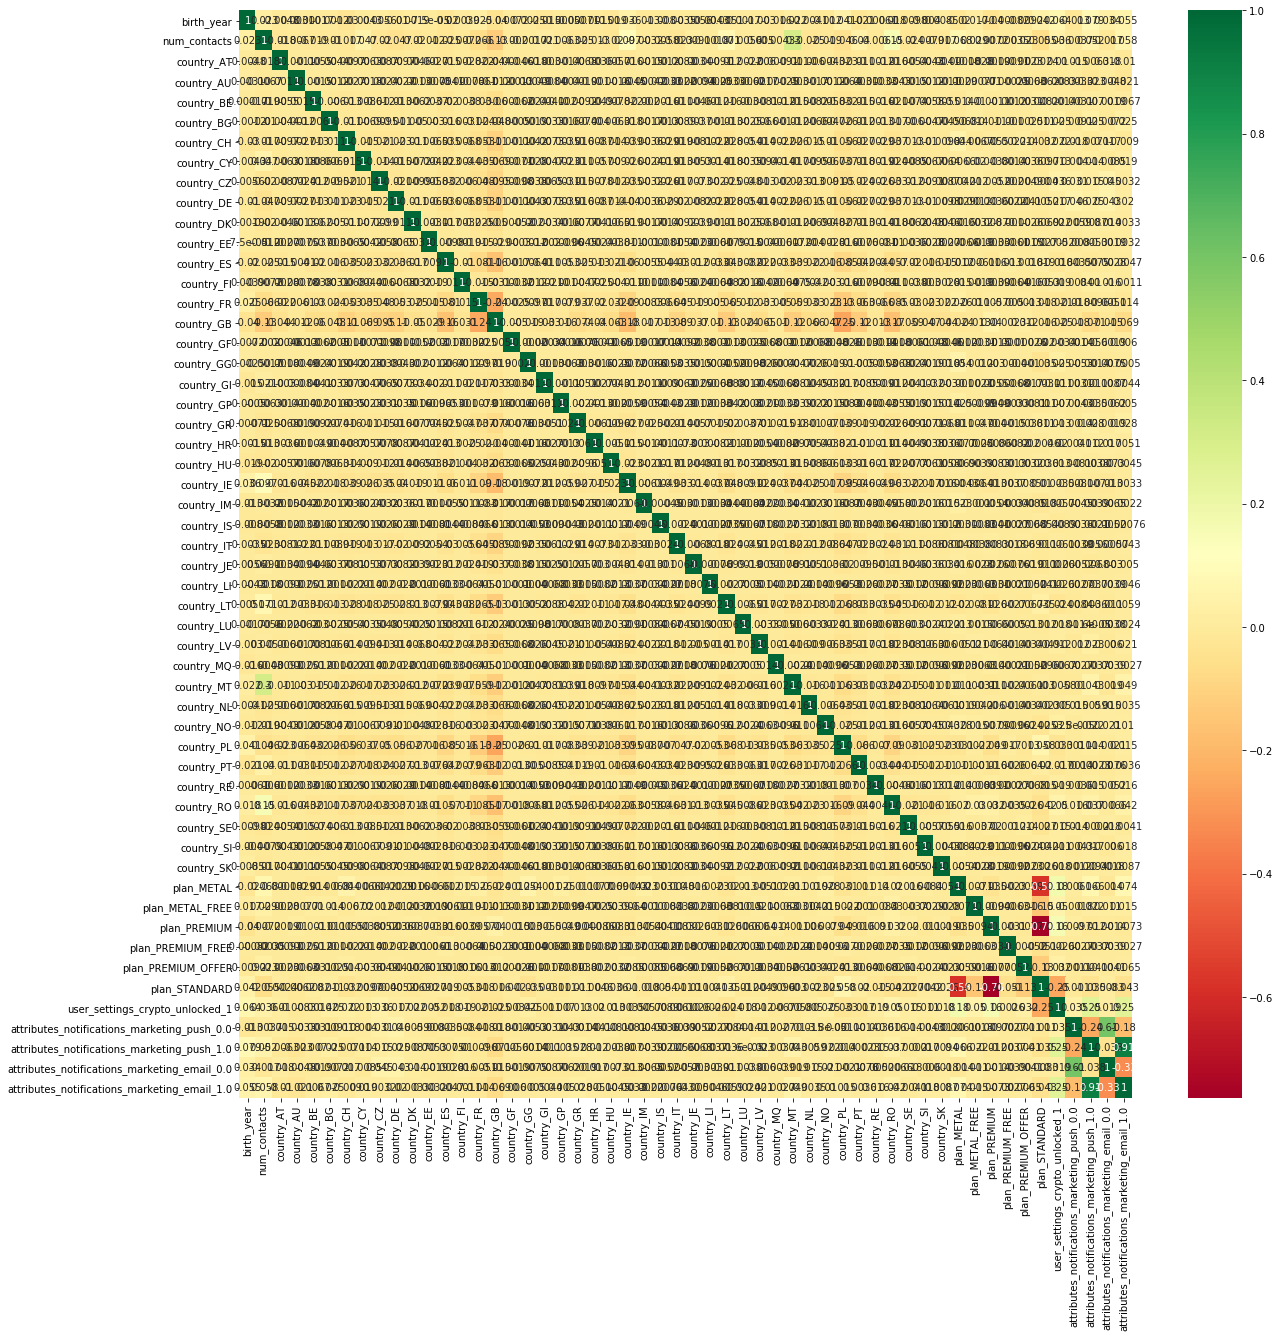

In [27]:
# plot heat map correlations of each features in dataset to identify highly correlated features

corrmat = df_users.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,20))
g = sns.heatmap(df_users[top_corr_features].corr(),annot = True,cmap = "RdYlGn")

In [28]:
# remove features that could overfit the model

df_users.drop(['plan_METAL', 'plan_PREMIUM', 
               'attributes_notifications_marketing_push_1.0', 
               'attributes_notifications_marketing_email_0.0'], axis = 1, inplace = True)

#### Building a Random Forest Classifier

In [29]:
# combine dataframes, features directly correlated to target metrc are excluded to avoid overfitting

dfs = [df_users, df_devices, df_notifications, 
       df_transactions[['user_id', 'average_transaction_amount', 'engaged']]]

df_joined = reduce(lambda left,right: pd.merge(left, right,
                   on = 'user_id', how = 'inner'), dfs).reset_index(drop = True)

In [30]:
# pull out target variable

X = df_joined.drop(['user_id', 'engaged'],axis = 1)
y = df_joined['engaged'].astype(int)

In [31]:
# train and test data with K-Fold cross validaion
# note: n_trees and n_splits were fine-tuned prior to this

kf = KFold(n_splits = 6)

def run_clf(X, y):
    """carries out cross validation with KFold"""    
    y_pred = []
    y_exp = []
    clf = RandomForestClassifier(n_estimators = 40)
    for train_index, test_index in kf.split(X, y):
        
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)

        y_pred.extend(clf.predict(X_test))
        y_exp.extend(y_test)

    return y_exp, y_pred

In [32]:
# check performance

clf = RandomForestClassifier(n_estimators=40)
y_exp, y_pred = run_clf(X, y)
print("Accuracy: ""%.3f" %accuracy_score(y_exp, y_pred))
print("Precision: ""%.3f" %precision_score(y_exp, y_pred))
print("Recall: ""%.3f" %recall_score(y_exp, y_pred))
print("F1-score: ""%.3f" %f1_score(y_exp, y_pred))

Accuracy: 0.889
Precision: 0.908
Recall: 0.964
F1-score: 0.935


Confusion matrix
[[ 432  342]
 [ 118 3627]]


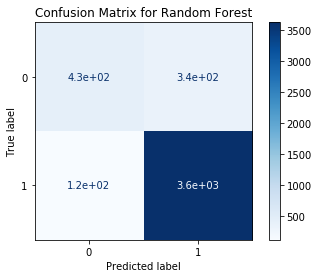

In [33]:
# plot confusion matrix

clf = RandomForestClassifier(n_estimators=40)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
clf.fit(X_train, y_train)

disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)

disp.ax_.set_title('Confusion Matrix for Random Forest')

print("Confusion matrix")
print(disp.confusion_matrix)

plt.show()

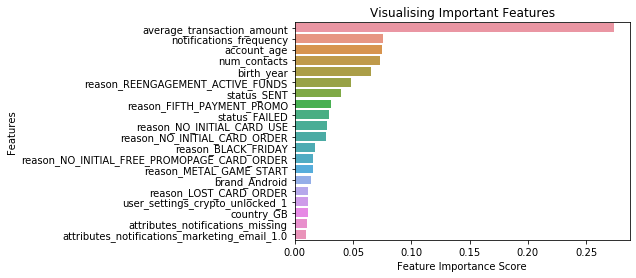

In [34]:
# feature importance

feature_imp = pd.Series(clf.feature_importances_,index = X.columns).sort_values(ascending = False)

# create a bar plot to display top 20 features

sns.barplot(x = feature_imp.nlargest(20), y = feature_imp.nlargest(20).index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualising Important Features")
plt.show()

In [35]:
# train and test model again with only the top 15 features

clf = RandomForestClassifier(n_estimators=40)
y_exp, y_pred = run_clf(X[feature_imp.nlargest(25).index], y)
print("Accuracy: ""%.3f" %accuracy_score(y_exp, y_pred))
print("Precision: ""%.3f" %precision_score(y_exp, y_pred))
print("Recall: ""%.3f" %recall_score(y_exp, y_pred))
print("F1-score: ""%.3f" %f1_score(y_exp, y_pred))

Accuracy: 0.889
Precision: 0.910
Recall: 0.961
F1-score: 0.935


We can see by only running with the top 25 features, we have further improved the model performance by reducing noise.

Random forests:


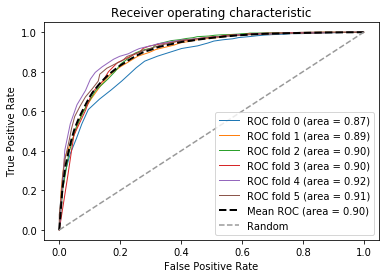

In [36]:
# plot ROC curve to visualise the performance of the model

y_prob = np.zeros((len(y),2))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train,y_train)
    y_prob[test_index] = clf.predict_proba(X_test)        
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[test_index, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
mean_tpr /= 6
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label = 'Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
print ("Random forests:")
plt.show()

We can determine which of the folds predicts the classes best.

### Set a test to see if we are reducing churn
* **How to set up?**
<br>Carry out a Paired Samples T-Test. We select a random population from all the 'unengaged' users above and compare their transaction frequencies before-and-after the business actions are being deployed. It is a hypothesis test where you have two competing hypotheses, namely:
<br> The Null hypothesis - the true mean difference between the paired sample is zero, the business actions did not work. 
<br> The Alternative hypothesis - the true mean difference is not equal to zero, the business actions reduced churn.



* **What metrics to measure impact of the business action?**
<br>From the selected population of unengaged users, we measure their transaction frequencies in the 30 days before the business action is deployed, which will then be compared with those in the 30 days after the deployment (ie. transaction count over 30 days). Procedures include calcuating the difference between the two observations on each pair, calculate the mean difference and the standard deviation and hence the standard error of the mean difference. It will finally be used to challenge the 95% confidence interval, if our calculated t-value lies above the critical t-value in the upper tail, we are confident to say that the business action is effective and we are reducing churn.

Assumptions for t-tests:
* The dependent variable must be continuous - transaction frequency
* The observations are independent of one another - users are independent
* The dependent variable should be approximately normally distributed - achieved by log-transform
* The dependent variable should not contain any outliers - achieved by log-transform


In [37]:
# export csv

df_joined.to_csv('data/new_data.csv')